(32, 32, 3)


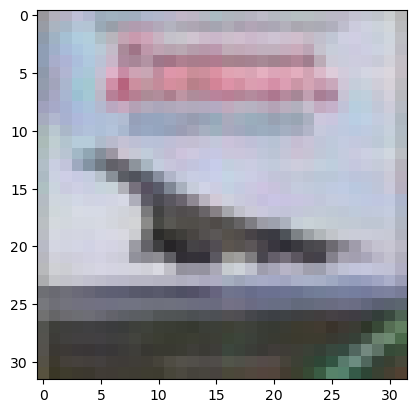

torch.Size([3, 32, 32])
torch.Size([1, 3, 32, 32])
tensor([3])


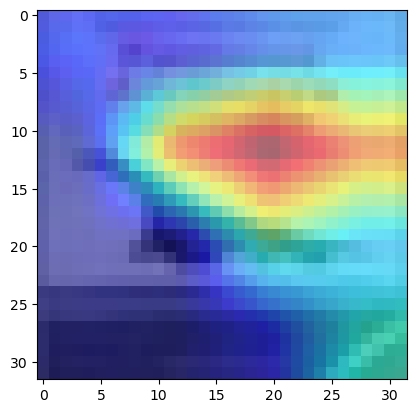

In [1]:
import numpy
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from utils import GradCAM, show_cam_on_image

class Residual(nn.Module):
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)


def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk


b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   # nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
                    )

b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))


net.load_state_dict(torch.load('resnet18.params'))
trans = transforms.Compose([transforms.ToTensor()])
img = Image.open('cifar10_test/cifar10_test03.jpg').resize((32, 32))

img = numpy.array(img, dtype=numpy.uint8)
print(img.shape)
plt.imshow(img)
plt.show()

img_tensor = trans(img)
print(img_tensor.shape)
input = torch.unsqueeze(img_tensor, dim=0)
print(input.shape)
y = net(input)
print(torch.argmax(y, 1))

cam = GradCAM(model=net, target_layers=[net[-4]], use_cuda=True)
target_category = 3
rgb_cam = cam(input, target_category)
rgb_cam = rgb_cam[0, :]
visualization = show_cam_on_image(img.astype(dtype=numpy.float32) / 255.,
                                  rgb_cam, use_rgb=True)
plt.imshow(visualization)
plt.show()

